In [1]:
import csv
import pandas as pd
import numpy as np
import os
import torch
import pickle
import datetime
from torch.utils.data import TensorDataset, DataLoader

In [2]:
! ls data

lvl2_train.pkl	Ys_train.pkl


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
def pick_easy_tasks(model, x, mask, y, N, K, epoch):
    criterion = nn.BCELoss(reduction='none')
    model.train(False)
    y_hat = model(x, mask)

    # Pick tasks in the batch for which the loss is less than 1 / N.
    loss = torch.add((1 / GAMMA) * criterion(y_hat, y), -1 / N)
    easy_indices = list((loss < 0).nonzero()) if epoch >= K else list(loss.nonzero())
    print(f"indices picked: {len(easy_indices)}, K: {K}, epoch: {epoch}")

    easy_timeseries = torch.empty((len(easy_indices), x.size()[1], x.size()[2]))
    easy_masks = torch.empty((len(easy_indices), x.size()[1], x.size()[2]))
    easy_labels = torch.empty((len(easy_indices),))

    for i, index in enumerate(easy_indices):
        index = index.item()
        easy_timeseries[i] = x[index]
        easy_masks[i] = mask[index]
        easy_labels[i] = y[index]

    model.train(True)
    return torch.Tensor(easy_timeseries).to(device), torch.Tensor(easy_masks).to(device), torch.Tensor(easy_labels).to(device)

In [5]:
with open("data/lvl2_train.pkl", "rb") as f:
    data = pickle.load(f).sort_values(['subject_id', 'hadm_id', 'icustay_id'])

with open("data/Ys_train.pkl", "rb") as f:
    labels = pickle.load(f).sort_values(['subject_id', 'hadm_id', 'icustay_id'])
    
data = data.reset_index(drop=True).droplevel(level="LEVEL2", axis=1)
features = data["mean"].to_numpy()
masks = data["mask"].to_numpy()

features = np.split(features, [48 * i for i in range(1, len(features) // 48)])
masks = np.split(masks, [48 * i for i in range(1, len(masks) // 48)])

features = torch.tensor(features, dtype=torch.float).to(device)
masks = torch.tensor(masks, dtype=torch.float).to(device)
labels = torch.squeeze(torch.tensor(labels.to_numpy(), dtype=torch.float).to(device))

print(f"Shape of features: {features.size()}")
print(f"Shape of masks: {masks.size()}")
print(f"Shape of labels: {labels.size()}")
assert len(features) == len(labels)
assert features.size() == masks.size()

/tmp/ipykernel_1908592/3938625581.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /scratch/env/opence1.5.1/conda-bld/pytorch-base_1643072044833/work/torch/csrc/utils/tensor_new.cpp:201.)
  features = torch.tensor(features, dtype=torch.float).to(device)


Shape of features: torch.Size([15591, 48, 104])
Shape of masks: torch.Size([15591, 48, 104])
Shape of labels: torch.Size([15591])


In [6]:
lengths = [int(round(len(features) * 8 / 10)), int(round(len(features) / 10)), int(round(len(features) / 10))]
splits = [lengths[0], lengths[0] + lengths[1]]

train_features = features[0:splits[0]]
train_masks = masks[0:splits[0]]
train_labels = labels[0:splits[0]]

def create_easy_train_dataloader(model, N, K, epoch):
    easy_timeseries, easy_masks, easy_labels = pick_easy_tasks(model, train_features, train_masks, train_labels, N, K, epoch)
    easy_train_dataset = TensorDataset(easy_timeseries, easy_masks, easy_labels)
    if len(easy_train_dataset) == 0:
        return None, len(train_features)
    return DataLoader(easy_train_dataset, batch_size=32, shuffle=True), len(train_features)

test_dataset = TensorDataset(features[splits[0]:splits[1]], masks[splits[0]:splits[1]], labels[splits[0]:splits[1]])
validation_dataset = TensorDataset(features[splits[1]:], masks[splits[1]:], labels[splits[1]:])

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
validation_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False)

print(f"Train dataset size: {len(train_features)} ICU stays with 48-hour timeseries for {features.size()[2]} measurements each")
print(f"Test dataset size: {len(test_dataset)} ICU stays with 48-hour timeseries for {features.size()[2]} measurements each")
print(f"Validation dataset size: {len(validation_dataset)} ICU stays with 48-hour timeseries for {features.size()[2]} measurements each")

Train dataset size: 12473 ICU stays with 48-hour timeseries for 104 measurements each
Test dataset size: 1559 ICU stays with 48-hour timeseries for 104 measurements each
Validation dataset size: 1559 ICU stays with 48-hour timeseries for 104 measurements each


In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

constant_classifier = DummyClassifier(strategy="constant", constant=1)
uniform_classifier = DummyClassifier(strategy="uniform")

inputs, labels = None, None
for inp, mask, lab in validation_dataloader:
    inputs, labels = inp, lab
    labels = labels.clone().cpu().detach()

constant_classifier.fit([0] * len(labels), labels)
uniform_classifier.fit([0] * len(labels), labels)
y_constant = constant_classifier.predict([0] * len(labels))
y_uniform = uniform_classifier.predict([0] * len(labels))

print(f"Baseline F1 score constant 1: {f1_score(labels, y_constant)}")
print(f"Baseline F1 score uniform: {f1_score(labels, y_uniform)}")

Baseline F1 score constant 1: 0.1506524317912218
Baseline F1 score uniform: 0.14722536806342015


In [8]:
GAMMA = 0.5
N = 16
LAMBDA = 1.3
LR = 0.001
OMEGA = 0.001
K = 1

In [9]:
import torch.nn as nn
import torch.nn.utils.rnn as rnn

class TinyModel(torch.nn.Module):
    def __init__(self):
        super(TinyModel, self).__init__()
        self.rnn = nn.GRU(input_size=104, hidden_size=32, num_layers=1, bidirectional=False, batch_first=True)
        self.fc1 = nn.Linear(in_features=32, out_features=1)

    def forward(self, x, mask):
        try:
            x = x * mask
        except:
            print(x, mask)
        _, h_n = self.rnn(x)
        fc1_out = self.fc1(torch.squeeze(h_n))
        # Multiply prediction value before sigmoid activation by gamma.
        # This is part of the micro framework.
        r = torch.mul(fc1_out, GAMMA)
        res = torch.sigmoid(r)
        return torch.squeeze(res)

tinymodel = TinyModel()
tinymodel.to(device)

print('The model:')
print(tinymodel)

The model:
TinyModel(
  (rnn): GRU(104, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


In [10]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(tinymodel.parameters(), LR)

def loss_func(y_hat, y, model):
    # Add a dimension when there is only one item in the batch.     
    if len(y_hat.size()) == 0:
        y_hat = torch.unsqueeze(y_hat, dim=0)

    l1 = OMEGA * sum(p.abs().sum() for p in model.parameters())
    cr = (1 / GAMMA) * criterion(y_hat, y)
    
    # Calculate the loss. The regularization is just an l1 regularization with a coefficient.
    # The criterion is the binary cross-entropy multiplied by 1 / GAMMA, a part of the micro framework.
    return l1 + cr

    # The paper also says to subtract batch_size / N, but this value is different for different batches depending
    # on the number of easy tasks in the batch, making it hard to compare loss across batches. Crucially, this 
    # is confusing when you look at the loss on training data (non-full batches) vs loss on testing data (full-size batches).
    # This makes me think that actually the paper meant that you first pick easy tasks across the entire testing set,
    # and then split it into batches rather than split into batches first and pick easy tasks after.
#     batch_size = y_hat.size()[0]    
#     neg = batch_size / N
#     return l1 + cr - neg

In [11]:
# TODO: implement early stopping
for epoch in range(16):
    running_loss = 0.0
    number_examples_used = 0
    dataloader, max_num_examples = create_easy_train_dataloader(tinymodel, N, K, epoch)
    
    if dataloader is not None:
        for i, (features, masks, labels) in enumerate(dataloader):
            tinymodel.train(True)
            optimizer.zero_grad()

            # Train on easy sequences.
            output = tinymodel(features, masks)
            loss = loss_func(output, labels, tinymodel)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            number_examples_used += len(features)
            if (i + 1) % 50 == 0:
                print(f'Epoch: [{epoch + 1}, training batch {i + 1:5d}] running training loss: {running_loss / 50:.3f}')
                running_loss = 0.0
    
    running_test_loss = 0.0
    tinymodel.train(False)
    print(f"In epoch {epoch + 1}, number of examples trained on is {number_examples_used} out of {max_num_examples}")
    for i, (test_inputs, test_masks, test_labels) in enumerate(test_dataloader):
        test_outputs = tinymodel(test_inputs, test_masks)
        test_loss = loss_func(test_outputs, test_labels, tinymodel)
        running_test_loss += test_loss
    
    print(f"Test loss: {running_test_loss / len(test_dataloader)}")
    # Once we have passed K warm-up epochs, decrease N by a factor of lambd
    # and as such increase 1 / N, so increase the loss threshold that defines
    # what tasks are considrered easy.
    if epoch >= K:
        N = N / LAMBDA
    print(f"N is now {N}\n\n")

print("Finished Training")

indices picked: 12473, K: 1, epoch: 0
Epoch: [1, training batch    50] running training loss: 2.235
Epoch: [1, training batch   100] running training loss: 1.338
Epoch: [1, training batch   150] running training loss: 0.862
Epoch: [1, training batch   200] running training loss: 0.641
Epoch: [1, training batch   250] running training loss: 0.599
Epoch: [1, training batch   300] running training loss: 0.584
Epoch: [1, training batch   350] running training loss: 0.590
In epoch 1, number of examples trained on is 12473 out of 12473
Test loss: 0.6373447775840759
N is now 16


indices picked: 1, K: 1, epoch: 1
In epoch 2, number of examples trained on is 1 out of 12473
Test loss: 0.6367767453193665
N is now 12.307692307692307


indices picked: 107, K: 1, epoch: 2
In epoch 3, number of examples trained on is 107 out of 12473
Test loss: 0.6357297301292419
N is now 9.467455621301774


indices picked: 2366, K: 1, epoch: 3
Epoch: [4, training batch    50] running training loss: 0.187
In epoch 4

In [12]:
from sklearn.metrics import f1_score, roc_auc_score

tinymodel.train(False)
out = None
lab = None
for inputs, masks, labels in validation_dataloader:
    outputs = tinymodel(inputs, masks)
    out = outputs
    outputs = outputs > 0.5
    lab = labels
    labels = labels.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    print(f"F1 score: {f1_score(labels, outputs)}")
    print(f"ROC AUC: {roc_auc_score(labels, outputs)}")

F1 score: 0.07462686567164178
ROC AUC: 0.5189867153477323


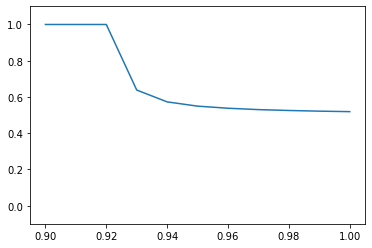

Area under the metric-coverage plot: 0.07394205579075401


In [22]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Fill with real values
preds = out.cpu().detach().numpy()

def mean(x):
    return sum(x) / len(x)

coverages = []
calculated_metrics = []
    
criterion = nn.BCELoss(reduction='none')
loss = (1 / GAMMA) * criterion(out, lab)
ordered_indices = torch.argsort(loss)
ordered_outputs = 1.0 * (torch.index_select(out, 0, ordered_indices) > 0.5)
ordered_labels = torch.index_select(lab, 0, ordered_indices)

ordered_outputs = ordered_outputs.cpu().detach().numpy()
ordered_labels = ordered_labels.cpu().detach().numpy()

AUC = 0

for coverage in np.arange(0.9, 1.01, 0.01):
    length = len(ordered_outputs)
    cutoff_index = int(length * coverage) + 1
    
    included_outputs = ordered_outputs[0:cutoff_index]
    included_labels = ordered_labels[0:cutoff_index]
    
    metric = metrics.roc_auc_score(included_labels, included_outputs)
    calculated_metrics.append(metric)
    coverages.append(coverage)
    
    AUC += metric * 0.01
    
plt.plot(coverages, calculated_metrics)
plt.ylim(-0.1, 1.1)
plt.show()
print(f"Area under the metric-coverage plot: {AUC}")

In [18]:
print(coverages)

[0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.9600000000000001, 0.9700000000000001, 0.9800000000000001, 0.9900000000000001, 1.0]
